# Sentiment Analysis on Hotel Reviews to Improve Customer Satisfaction – Turmeric Hotel


##  Goal

To analyze customer reviews from multiple platforms using sentiment analysis in order to understand guest satisfaction levels and identify improvement areas that can enhance service quality and customer experience at the hotel.

##  Problem Statement

Hotel businesses receive hundreds of online reviews every month, making it challenging to manually track customer satisfaction trends, common complaints, or praises. This leads to delayed responses to critical service issues and missed opportunities to delight guests.

By leveraging sentiment analysis, we can automatically extract emotions and patterns from reviews and turn them into actionable insights for hotel management to boost guest satisfaction and brand image.


## Objectives:
- Preprocess and clean the raw review texts for analysis.

- Perform sentiment analysis (Positive, Negative, Neutral) using NLP techniques (e.g., Vader).

- Visualize sentiment distribution across different platforms (TripAdvisor, Google, MMT, Booking.com).

- Analyze sentiment by trip type (solo, family, couple, business, friends) to identify experience-based satisfaction.

- Identify top positive and negative keywords from reviews (e.g., "clean", "friendly", "delay", "rude").

- Provide actionable insights to help the hotel improve services and guest experience.

##  Key Business KPIs

The following KPIs are used to evaluate guest satisfaction and identify service improvement areas:

### 🔹 High-Level KPIs (For Quick Insight)
-  Average Overall Rating
-  % Positive vs. % Negative Reviews
-  Time-based Sentiment Trend (Monthly)
-  Sentiment by Trip Type (Family, Solo, Business, etc.)
-  Top Issues in Negative Reviews (Common Complaints)
-  Room, Service, Location Rating Breakdown
-  Platform-wise Sentiment Ratio



In [6]:
# Data Handling
import pandas as pd
import numpy as np

# Text Preprocessing
import re
import string

# NLP & Sentiment
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [8]:
df = pd.read_csv('turmeric_hotel.csv')


In [10]:
df.head()

,reviews,overall_rating,review_date,trip_type,room_rating,service_rating,location_rating,platform
0,We booked this 4-star hotel expecting a comfor...,1,Jun-25,family,3.0,1.0,3.0,google
1,I had a wonderful stay for two days. The check...,5,Apr-25,NaN,5.0,5.0,4.0,google
2,Had a great one-day stay here! Everything was ...,5,Jun-25,friends,5.0,5.0,5.0,google
3,I had a wonderful stay at Hotel Turmeric in Er...,5,Apr-25,friends,5.0,5.0,5.0,google
4,We stayed here for a night. We had a comfortab...,5,Jun-25,family,5.0,5.0,5.0,google


In [12]:
df.shape

(258, 8)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reviews          258 non-null    object 
 1   overall_rating   258 non-null    int64  
 2   review_date      258 non-null    object 
 3   trip_type        248 non-null    object 
 4   room_rating      257 non-null    float64
 5   service_rating   257 non-null    float64
 6   location_rating  257 non-null    float64
 7   platform         258 non-null    object 
dtypes: float64(3), int64(1), object(4)
memory usage: 16.3+ KB


In [16]:
df.isnull().sum()

reviews             0
overall_rating      0
review_date         0
trip_type          10
room_rating         1
service_rating      1
location_rating     1
platform            0
dtype: int64

In [18]:
df.duplicated().sum()

1

In [20]:
df.drop_duplicates(inplace=True)

In [22]:
df.shape

(257, 8)

In [24]:
df['trip_type'] = df['trip_type'].fillna(df['trip_type'].mode()[0])

In [26]:
df['room_rating'] = df['room_rating'].fillna(df['room_rating'].median())
df['service_rating'] = df['service_rating'].fillna(df['service_rating'].median())
df['location_rating'] = df['location_rating'].fillna(df['location_rating'].median())


In [28]:
# Just get review_month and review_year from the original string
df['review_month'] = pd.to_datetime(df['review_date'].astype(str).str.strip(), format='%b-%y', errors='coerce').dt.to_period('M')
df['review_year'] = df['review_month'].dt.year

In [30]:
# Drop the original review_date if not needed
df.drop(columns=['review_date'], inplace=True)

In [32]:
df.isnull().sum()

reviews            0
overall_rating     0
trip_type          0
room_rating        0
service_rating     0
location_rating    0
platform           0
review_month       1
review_year        0
dtype: int64

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257 entries, 0 to 257
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   reviews          257 non-null    object   
 1   overall_rating   257 non-null    int64    
 2   trip_type        257 non-null    object   
 3   room_rating      257 non-null    float64  
 4   service_rating   257 non-null    float64  
 5   location_rating  257 non-null    float64  
 6   platform         257 non-null    object   
 7   review_month     256 non-null    period[M]
 8   review_year      257 non-null    int64    
dtypes: float64(3), int64(2), object(3), period[M](1)
memory usage: 20.1+ KB


In [36]:
df[df['review_month'].isnull()]


,reviews,overall_rating,trip_type,room_rating,service_rating,location_rating,platform,review_month,review_year
235,Nice for business people who look for a perfec...,4,business,4.0,4.0,4.0,trip advisor,NaT,-1


In [38]:
df = df[df['review_month'].notnull()]


In [40]:
df.shape


(256, 9)

In [42]:
df.isnull().sum()

reviews            0
overall_rating     0
trip_type          0
room_rating        0
service_rating     0
location_rating    0
platform           0
review_month       0
review_year        0
dtype: int64

In [44]:
print(df.columns.tolist())


['reviews ', 'overall_rating', 'trip_type', 'room_rating', 'service_rating', 'location_rating', 'platform', 'review_month', 'review_year']


In [46]:
df.rename(columns=lambda x: x.strip().lower(), inplace=True)


In [48]:
print(df.columns.tolist())


['reviews', 'overall_rating', 'trip_type', 'room_rating', 'service_rating', 'location_rating', 'platform', 'review_month', 'review_year']


In [50]:
stop_words = set(stopwords.words('english'))

def clean_review(text):
    if pd.isnull(text):
        return ""
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove numbers and punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    # Remove stopwords (optional)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [52]:
df['cleaned_reviews'] = df['reviews'].apply(clean_review)


In [54]:
df.head()

,reviews,overall_rating,trip_type,room_rating,service_rating,location_rating,platform,review_month,review_year,cleaned_reviews
0,We booked this 4-star hotel expecting a comfor...,1,family,3.0,1.0,3.0,google,2025-06,2025,booked star hotel expecting comfortable highqu...
1,I had a wonderful stay for two days. The check...,5,solo,5.0,5.0,4.0,google,2025-04,2025,wonderful stay two days checkin process seamle...
2,Had a great one-day stay here! Everything was ...,5,friends,5.0,5.0,5.0,google,2025-06,2025,great oneday stay everything easy comfortable ...
3,I had a wonderful stay at Hotel Turmeric in Er...,5,friends,5.0,5.0,5.0,google,2025-04,2025,wonderful stay hotel turmeric erode checkin pr...
4,We stayed here for a night. We had a comfortab...,5,family,5.0,5.0,5.0,google,2025-06,2025,stayed night comfortable stay rooms large tast...


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 256 entries, 0 to 257
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype    
---  ------           --------------  -----    
 0   reviews          256 non-null    object   
 1   overall_rating   256 non-null    int64    
 2   trip_type        256 non-null    object   
 3   room_rating      256 non-null    float64  
 4   service_rating   256 non-null    float64  
 5   location_rating  256 non-null    float64  
 6   platform         256 non-null    object   
 7   review_month     256 non-null    period[M]
 8   review_year      256 non-null    int64    
 9   cleaned_reviews  256 non-null    object   
dtypes: float64(3), int64(2), object(4), period[M](1)
memory usage: 22.0+ KB


In [58]:
df['room_rating'] = df['room_rating'].astype(int)
df['service_rating'] = df['service_rating'].astype(int)
df['location_rating'] = df['location_rating'].astype(int)


In [60]:
df.to_csv("turmeric_cleaned_reviews.csv", index=False)


## Basic Descriptive Stats & Categorical Counts

### 1. Descriptive Summary of Ratings

In [66]:
df[['overall_rating', 'room_rating', 'service_rating', 'location_rating']].describe()


,overall_rating,room_rating,service_rating,location_rating
count,256.000000,256.000000,256.000000,256.000000
mean,4.054688,4.152344,3.933594,4.214844
std,1.370894,1.260343,1.422330,1.222636
min,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,3.000000,4.000000
50%,5.000000,5.000000,5.000000,5.000000
75%,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000


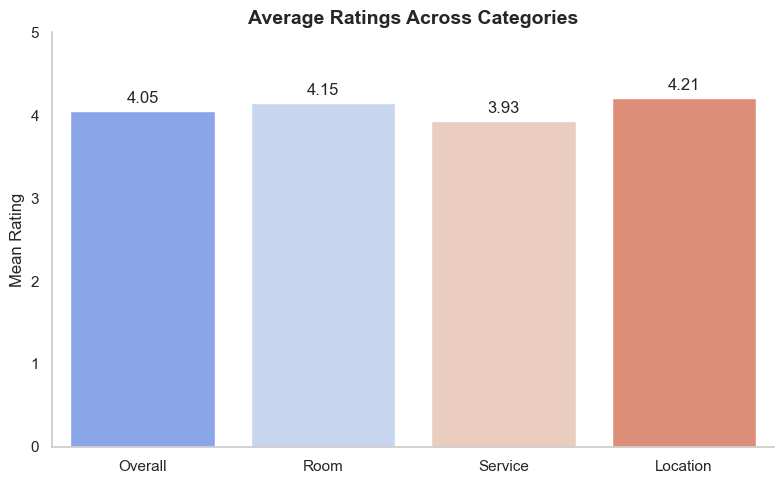

In [68]:
# Sample data (mean values, you can calculate from your actual dataset)
mean_values = {
    'Overall': 4.05,
    'Room': 4.15,
    'Service': 3.93,
    'Location': 4.21
}

# Convert to DataFrame
mean_df = pd.DataFrame(list(mean_values.items()), columns=['Rating Type', 'Mean Rating'])

# Set style
sns.set(style='whitegrid')

# Create the bar plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x='Rating Type', y='Mean Rating', data=mean_df, palette='coolwarm')

# Add value labels on top of bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')

# Set plot title and limits
plt.title('Average Ratings Across Categories', fontsize=14, fontweight='bold')
plt.ylim(0, 5)
plt.ylabel('Mean Rating')
plt.xlabel('')

# Remove gridlines as per storytelling best practices
sns.despine(right=True, top=True)
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


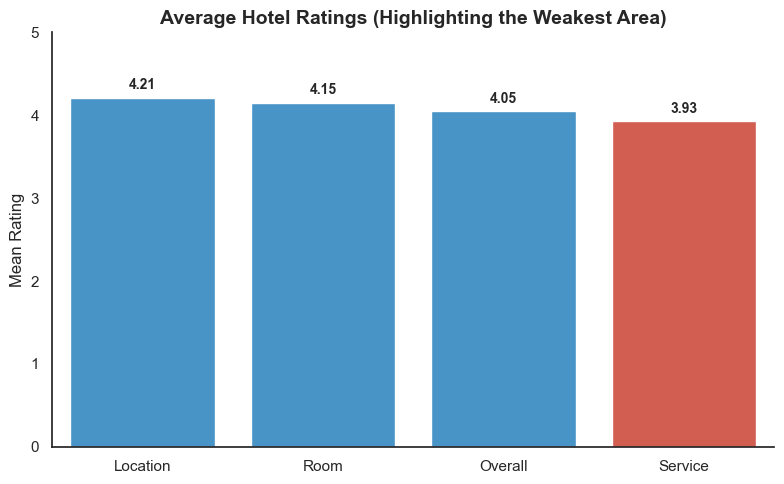

In [70]:
# Mean rating data
mean_values = {
    'Location': 4.21,
    'Room': 4.15,
    'Overall': 4.05,
    'Service': 3.93
}

# Convert to DataFrame
mean_df = pd.DataFrame(list(mean_values.items()), columns=['Rating Type', 'Mean Rating'])

# Identify the lowest rated category
min_rating = mean_df['Mean Rating'].min()

# Assign colors: red for lowest, blue for others
colors = ['#e74c3c' if rating == min_rating else '#3498db' for rating in mean_df['Mean Rating']]

# Sort if you want, optional
mean_df = mean_df.sort_values(by='Mean Rating', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.set(style='white')  # Clean white background

barplot = sns.barplot(
    x='Rating Type',
    y='Mean Rating',
    data=mean_df,
    palette=colors
)

# Add value labels
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), '.2f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=10, fontweight='bold'
    )

# Titles and layout
plt.title('Average Hotel Ratings (Highlighting the Weakest Area)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Rating', fontsize=12)
plt.xlabel('')
plt.ylim(0, 5)

# Clean up plot
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()

# Show plot
plt.show()


### 2. Review Count by Platform

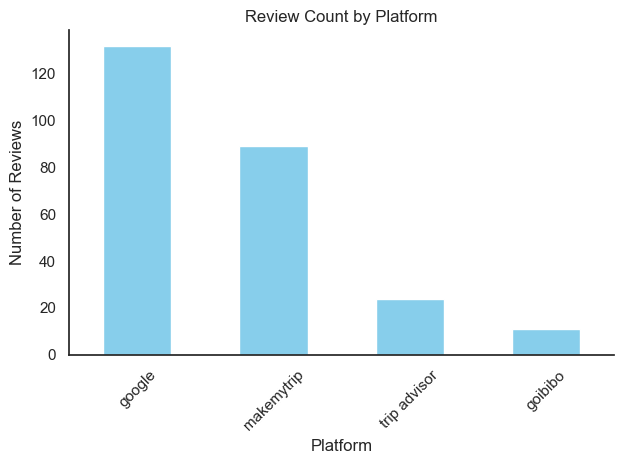

In [73]:
df['platform'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Review Count by Platform")
plt.xlabel("Platform")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()
plt.show()


### 3. Review Count by Trip Type

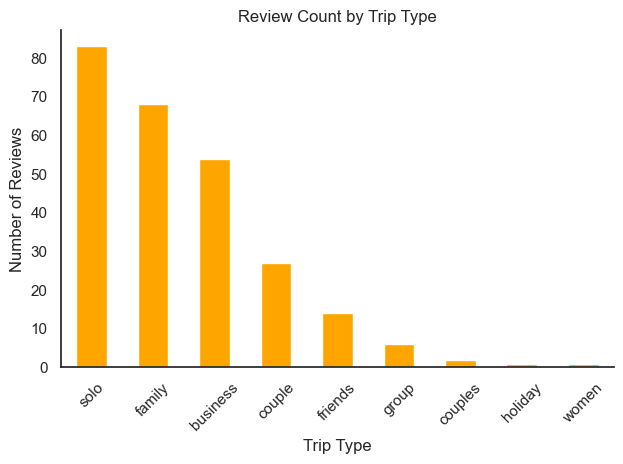

In [76]:
df['trip_type'].value_counts().plot(kind='bar', color='orange')
plt.title("Review Count by Trip Type")
plt.xlabel("Trip Type")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()
plt.show()


### 4. Review Volume Trend by Month

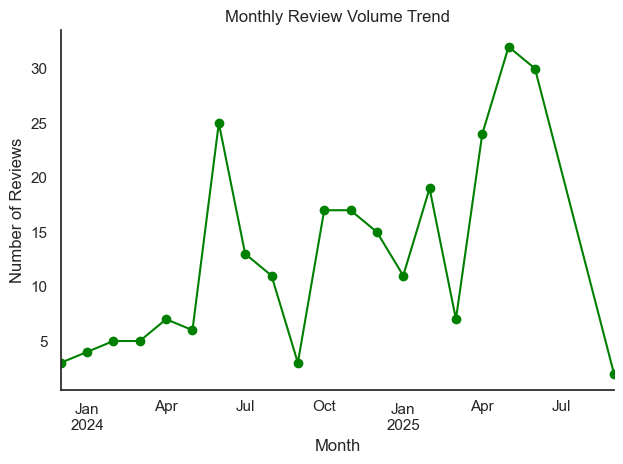

In [79]:
df['review_month'].value_counts().sort_index().plot(kind='line', marker='o', color='green')
plt.title("Monthly Review Volume Trend")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")


# Clean up plot
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()
plt.show()


## Rating-Based Analysis


### 1. Histogram of overall_rating

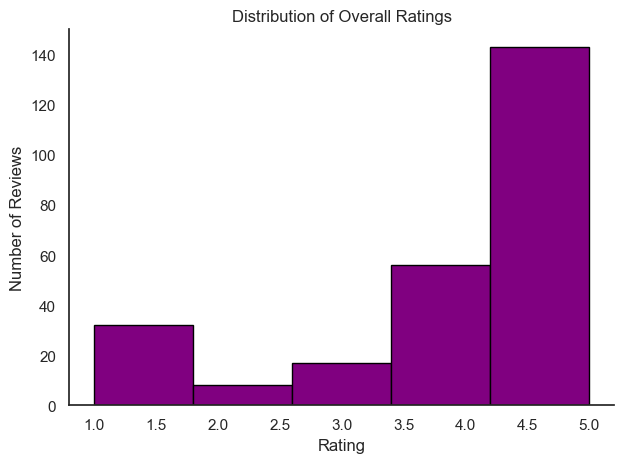

In [91]:
plt.hist(df['overall_rating'], bins=5, color='purple', edgecolor='black')
plt.title("Distribution of Overall Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()
plt.tight_layout()
plt.show()


### 2. Boxplot of Room, Service, Location Ratings

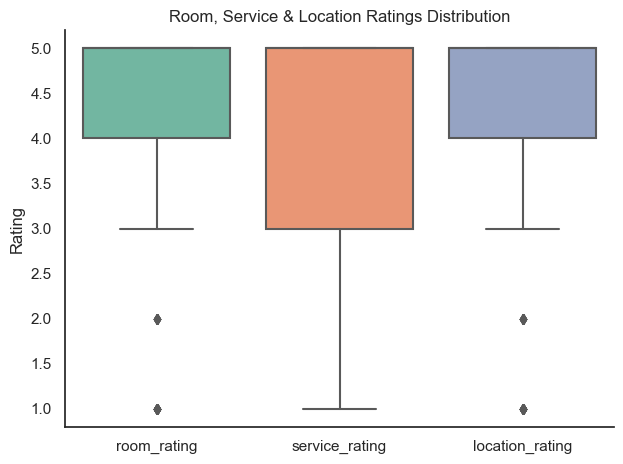

In [94]:
sns.boxplot(data=df[['room_rating', 'service_rating', 'location_rating']], palette='Set2')
plt.title("Room, Service & Location Ratings Distribution")
plt.ylabel("Rating")
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()
plt.show()


### 3. Average Rating by Platform

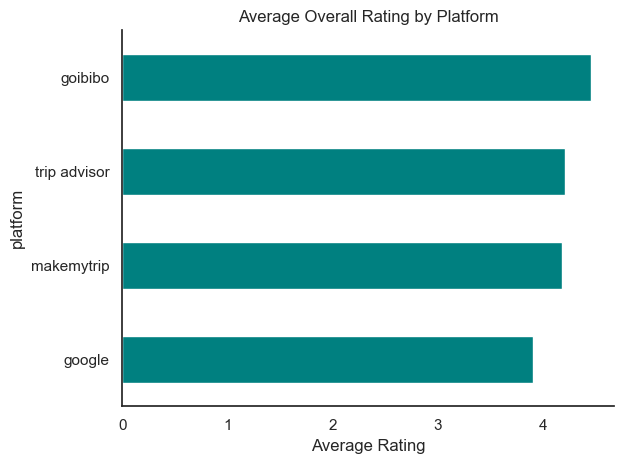

In [97]:
df.groupby('platform')['overall_rating'].mean().sort_values().plot(kind='barh', color='teal')
plt.title("Average Overall Rating by Platform")
plt.xlabel("Average Rating")

# Clean up plot
sns.despine(right=True, top=True)
plt.grid(False)

plt.tight_layout()
plt.show()


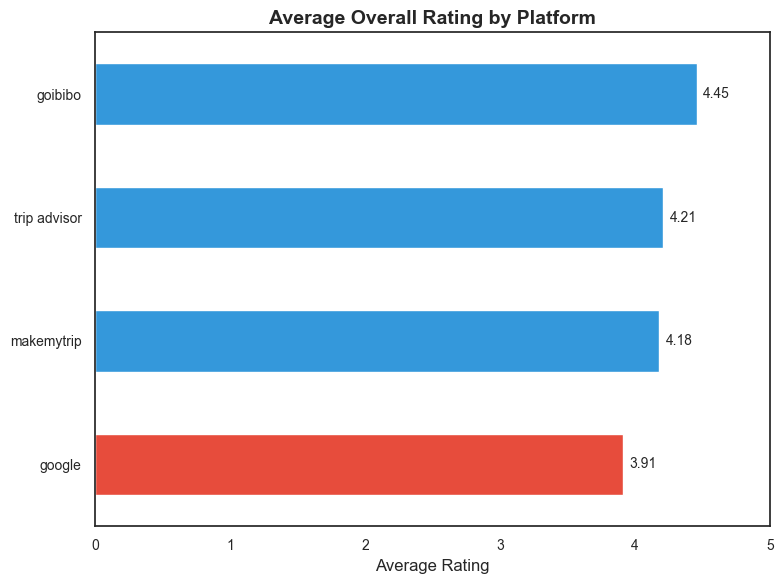

In [99]:
# Grouped mean values
platform_ratings = df.groupby('platform')['overall_rating'].mean().sort_values()

# Color: highlight the lowest-rated platform
min_rating = platform_ratings.min()
colors = ['#e74c3c' if rating == min_rating else '#3498db' for rating in platform_ratings]

# Plot
plt.figure(figsize=(8, 6))
bars = platform_ratings.plot(kind='barh', color=colors)

# Add value labels
for index, value in enumerate(platform_ratings):
    plt.text(value + 0.05, index, f'{value:.2f}', va='center', fontsize=10)

# Customize
plt.title('Average Overall Rating by Platform', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('')
plt.xlim(0, 5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)  # Clean look
plt.tight_layout()
plt.show()


### 4. Average Rating by Trip Type

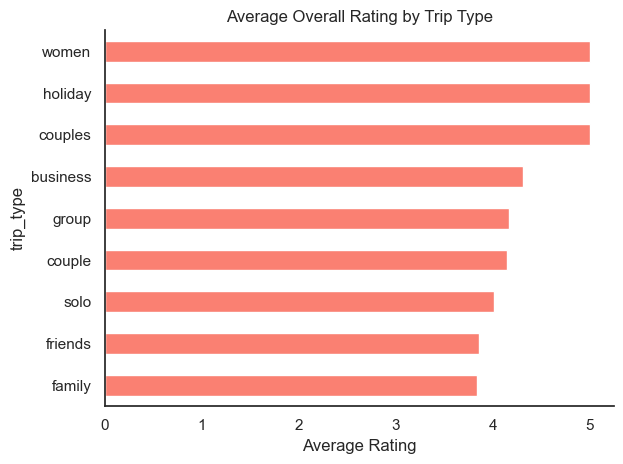

In [102]:
df.groupby('trip_type')['overall_rating'].mean().sort_values().plot(kind='barh', color='salmon')
plt.title("Average Overall Rating by Trip Type")
plt.xlabel("Average Rating")
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()
plt.show()


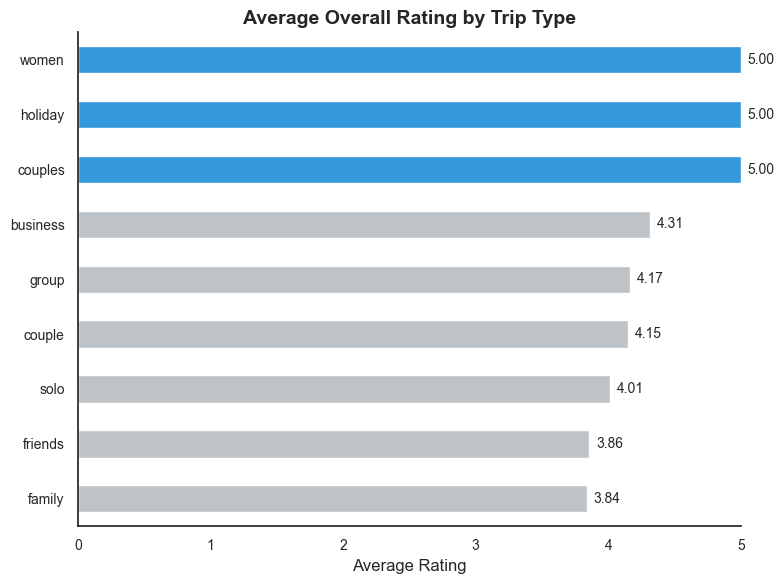

In [104]:
# Group and sort trip types by average rating
avg_ratings = df.groupby('trip_type')['overall_rating'].mean().sort_values()

# Find top 3 trip types with highest ratings
top_3 = avg_ratings.nlargest(3)

# Set colors: blue for top 3, grey for others
colors = ['#3498db' if trip in top_3.index else '#bdc3c7' for trip in avg_ratings.index]

# Plot
plt.figure(figsize=(8, 6))
bars = avg_ratings.plot(kind='barh', color=colors)

# Add value labels to each bar
for i, v in enumerate(avg_ratings):
    plt.text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=10)

# Customize plot
plt.title('Average Overall Rating by Trip Type', fontsize=14, fontweight='bold')
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('')
plt.xlim(0, 5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Clean up plot
sns.despine(right=True, top=True)
plt.grid(False)

plt.tight_layout()
plt.show()


## Time-Based Trend Analysis

### 1. Monthly Average Overall Rating Trend

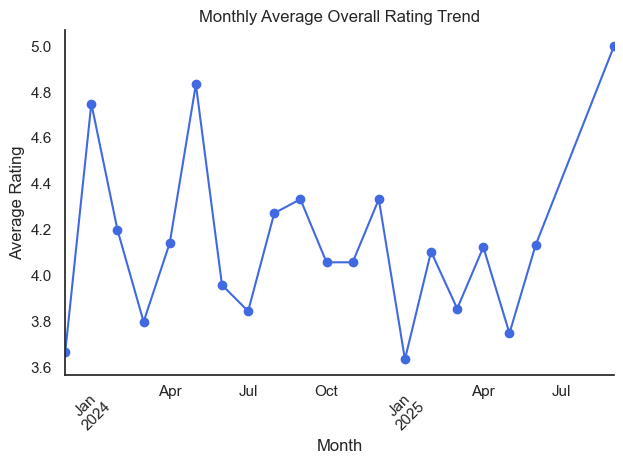

In [108]:
df.groupby('review_month')['overall_rating'].mean().plot(marker='o', color='royalblue')
plt.title("Monthly Average Overall Rating Trend")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.xticks(rotation=45)
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()
plt.show()


### 2. Monthly Average Ratings for Room, Service, Location

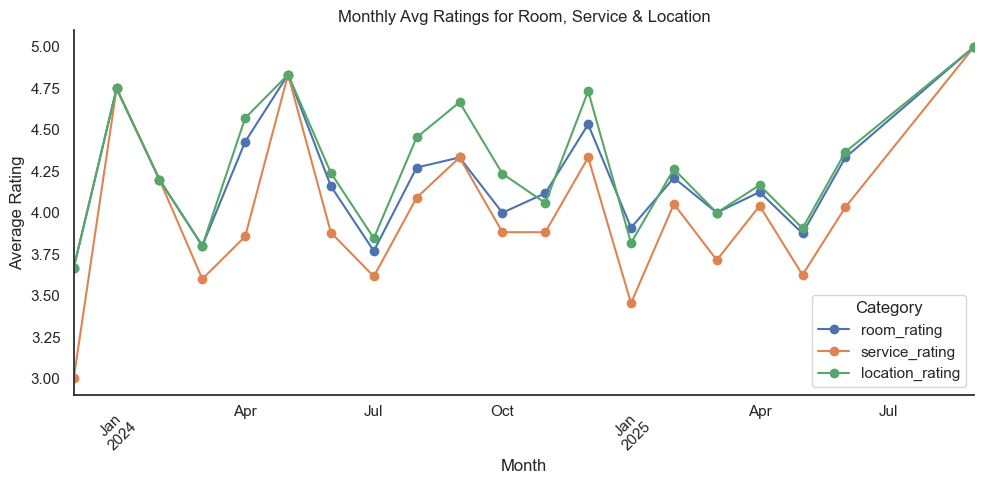

In [111]:
monthly_avg = df.groupby('review_month')[['room_rating', 'service_rating', 'location_rating']].mean()

monthly_avg.plot(marker='o', figsize=(10, 5))
plt.title("Monthly Avg Ratings for Room, Service & Location")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title="Category")

# Clean up plot
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()
plt.show()


##  Sentiment Analysis using VADER

In [114]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


In [116]:
#Create Sentiment Scores
df['sentiment_score'] = df['cleaned_reviews'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [118]:
#Classify Sentiment as Positive / Neutral / Negative
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(get_sentiment_label)


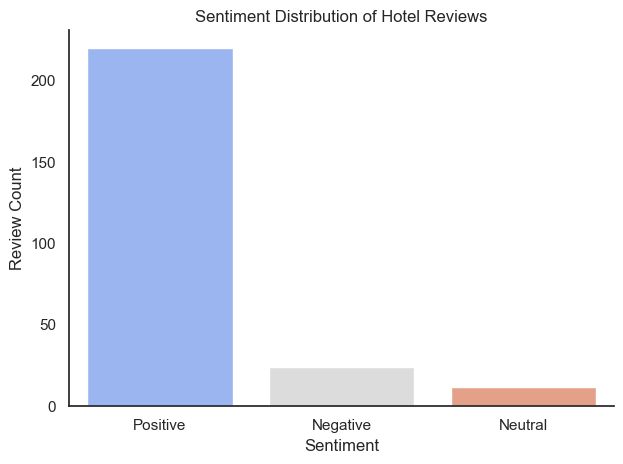

In [120]:
sns.countplot(x='sentiment_label', data=df, palette='coolwarm')
plt.title("Sentiment Distribution of Hotel Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Review Count")
plt.grid(axis='y')

# Clean up plot
sns.despine(right=True, top=True)
plt.grid(False)
plt.tight_layout()

plt.show()


## Keyword Extraction + WordClouds


In [123]:
positive_reviews = df[df['sentiment_label'] == 'Positive']['cleaned_reviews']
negative_reviews = df[df['sentiment_label'] == 'Negative']['cleaned_reviews']


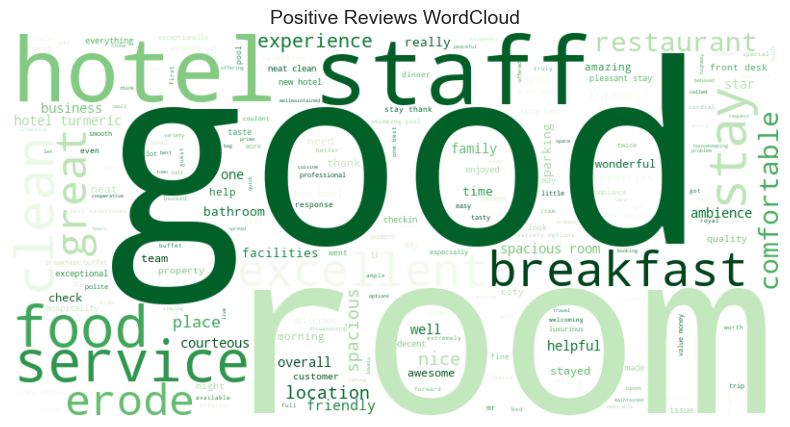

In [125]:
# Positive Review WordCloud
from wordcloud import WordCloud

text_pos = ' '.join(positive_reviews)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(text_pos)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud", fontsize=14)
plt.show()


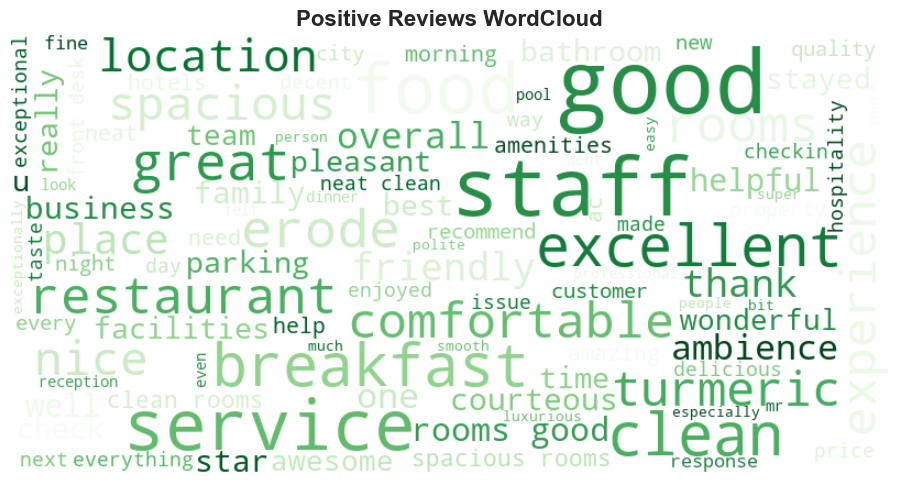

In [127]:
from wordcloud import WordCloud, STOPWORDS

# Combine all positive reviews into one string
text_pos = ' '.join(positive_reviews)

# Define stopwords (add custom if needed)
stopwords = set(STOPWORDS)
custom_stopwords = {'hotel', 'room', 'stay'}  # example domain-specific ones
stopwords.update(custom_stopwords)

# Generate WordCloud
wordcloud_pos = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens',
    stopwords=stopwords,
    max_words=100,
    max_font_size=80,
    min_font_size=10,
    random_state=42
).generate(text_pos)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


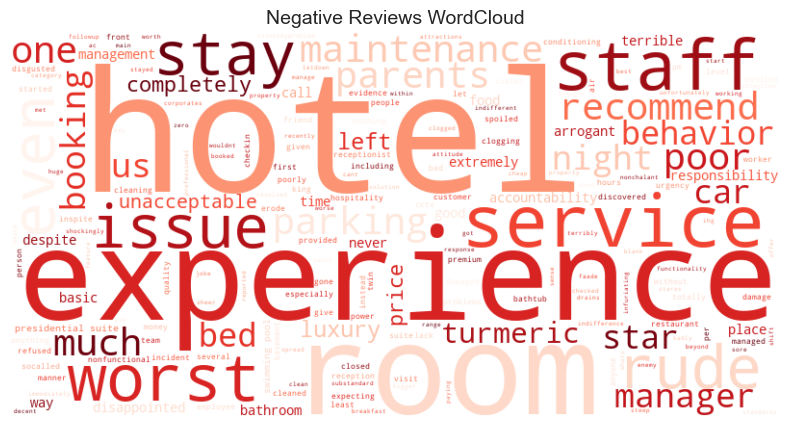

In [129]:
# Negative Review WordCloud

text_neg = ' '.join(negative_reviews)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text_neg)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud", fontsize=14)
plt.show()


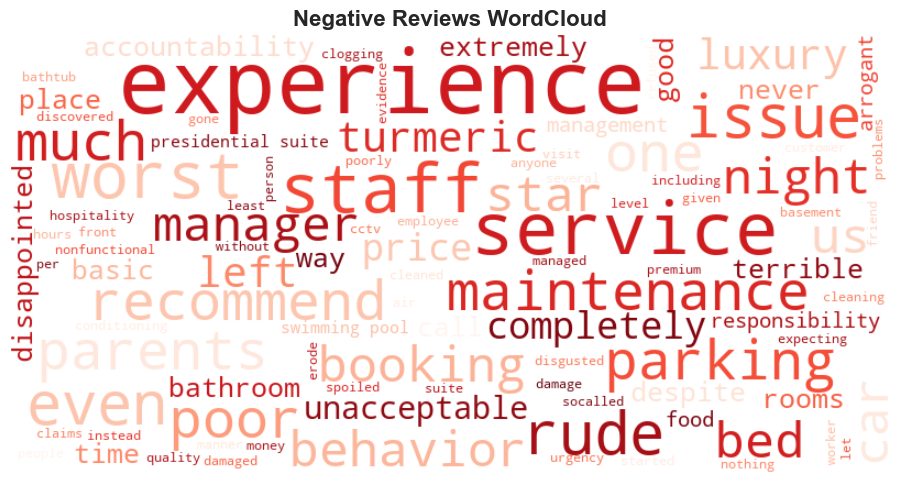

In [131]:
# Combine all negative reviews into one string
text_neg = ' '.join(negative_reviews)

# Define stopwords
stopwords = set(STOPWORDS)
custom_stopwords = {'hotel', 'room', 'stay'}  
stopwords.update(custom_stopwords)

# Generate WordCloud
wordcloud_neg = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    stopwords=stopwords,
    max_words=100,
    max_font_size=80,
    random_state=42
).generate(text_neg)

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [133]:
# Extract Top Complaint Keywords
from collections import Counter

# Flatten and count words
neg_words = ' '.join(negative_reviews).split()
neg_common = Counter(neg_words).most_common(10)

# Convert to DataFrame for neat viewing
neg_keywords_df = pd.DataFrame(neg_common, columns=['Keyword', 'Frequency'])
print(neg_keywords_df)


      Keyword  Frequency
0       hotel         21
1  experience         14
2        room         11
3     service          8
4       staff          8
5       worst          7
6        even          6
7        stay          6
8        rude          6
9       suite          5
